In [1]:
from google.colab import files
import os, cv2, math, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (8, 4)
plt.rcParams["axes.grid"] = True

print("Upload at least 3 short movement videos (MP4/MOV)...")
uploaded = files.upload()

video_paths = []
for name in uploaded.keys():
    path = "/content/" + name
    video_paths.append(path)
    print("Registered video:", path)

print(f"\nTotal videos uploaded: {len(video_paths)}")


Upload at least 3 short movement videos (MP4/MOV)...


Saving 9517848-uhd_4096_2160_24fps.mp4 to 9517848-uhd_4096_2160_24fps.mp4
Saving Good-young-man-exercising-in-living-room-384624-filmsupply.mov to Good-young-man-exercising-in-living-room-384624-filmsupply.mov
Saving 5319088-uhd_2160_3840_25fps.mp4 to 5319088-uhd_2160_3840_25fps.mp4
Registered video: /content/9517848-uhd_4096_2160_24fps.mp4
Registered video: /content/Good-young-man-exercising-in-living-room-384624-filmsupply.mov
Registered video: /content/5319088-uhd_2160_3840_25fps.mp4

Total videos uploaded: 3


In [2]:
def process_video_spatial(video_path, target_fps=4, min_area=200):
    """
    Perform simple spatial grounding via motion-based bounding boxes.
    Returns:
      df: per-frame metrics DataFrame
      summary: dict of per-video summary metrics
    """
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise RuntimeError(f"Could not open video: {video_path}")

    orig_fps = cap.get(cv2.CAP_PROP_FPS) or 30.0
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration_s = total_frames / orig_fps
    frame_interval = max(int(round(orig_fps / target_fps)), 1)

    diag_norm = None  # video diagonal for normalization

    records = []
    prev_sampled_frame = None
    prev_bbox = None

    idx = 0
    sample_idx = 0

    t0 = time.time()
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if idx % frame_interval != 0:
            idx += 1
            continue

        t_sec = idx / orig_fps

        # Init diag_norm
        if diag_norm is None:
            h, w = frame.shape[:2]
            diag_norm = math.sqrt(h**2 + w**2)

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        bbox = None
        area = 0
        iou = None
        center_disp_norm = None

        if prev_sampled_frame is not None:
            prev_gray = cv2.cvtColor(prev_sampled_frame, cv2.COLOR_BGR2GRAY)
            diff = cv2.absdiff(gray, prev_gray)
            # Threshold via Otsu
            _, mask = cv2.threshold(diff, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

            # Morphological opening + closing to clean noise
            kernel = np.ones((5, 5), np.uint8)
            mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
            mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

            contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            if contours:
                # Largest moving blob
                c = max(contours, key=cv2.contourArea)
                area = cv2.contourArea(c)
                if area >= min_area:
                    x, y, w, h = cv2.boundingRect(c)
                    bbox = (x, y, w, h)

                    # IoU vs previous bbox
                    if prev_bbox is not None:
                        x1, y1, w1, h1 = prev_bbox
                        xa1, ya1 = x1, y1
                        xa2, ya2 = x1 + w1, y1 + h1
                        xb1, yb1 = x, y
                        xb2, yb2 = x + w, y + h

                        inter_x1 = max(xa1, xb1)
                        inter_y1 = max(ya1, yb1)
                        inter_x2 = min(xa2, xb2)
                        inter_y2 = min(ya2, yb2)

                        inter_w = max(0, inter_x2 - inter_x1)
                        inter_h = max(0, inter_y2 - inter_y1)
                        inter_area = inter_w * inter_h
                        area_a = w1 * h1
                        area_b = w * h
                        union = area_a + area_b - inter_area
                        if union > 0:
                            iou = inter_area / union

                    # Center displacement vs previous bbox
                    if prev_bbox is not None and diag_norm > 0:
                        cx_old = prev_bbox[0] + prev_bbox[2] / 2.0
                        cy_old = prev_bbox[1] + prev_bbox[3] / 2.0
                        cx_new = x + w / 2.0
                        cy_new = y + h / 2.0
                        disp = math.sqrt((cx_new - cx_old)**2 + (cy_new - cy_old)**2)
                        center_disp_norm = disp / diag_norm

        # Save for next iteration
        prev_sampled_frame = frame.copy()
        if bbox is not None:
            prev_bbox = bbox

        records.append({
            "sample_idx": sample_idx,
            "frame_idx": idx,
            "time_sec": t_sec,
            "has_bbox": bbox is not None,
            "bbox_x": bbox[0] if bbox else np.nan,
            "bbox_y": bbox[1] if bbox else np.nan,
            "bbox_w": bbox[2] if bbox else np.nan,
            "bbox_h": bbox[3] if bbox else np.nan,
            "bbox_area": area,
            "iou_prev": iou,
            "center_disp_norm": center_disp_norm,
        })

        sample_idx += 1
        idx += 1

    cap.release()
    t1 = time.time()
    latency_s = t1 - t0
    rtf = duration_s / latency_s if latency_s > 0 else float("inf")

    df = pd.DataFrame(records)

    # Summary metrics
    coverage = df["has_bbox"].mean() if not df.empty else 0.0
    mean_iou = df["iou_prev"].mean(skipna=True) if not df.empty else float("nan")
    mean_center_disp = df["center_disp_norm"].mean(skipna=True) if not df.empty else float("nan")

    summary = {
        "video_path": video_path,
        "duration_s": duration_s,
        "num_samples": len(df),
        "latency_s": latency_s,
        "rtf": rtf,
        "coverage": coverage,
        "mean_iou_consecutive": mean_iou,
        "mean_center_disp_norm": mean_center_disp,
    }

    return df, summary



========== Track C – Video 1: /content/9517848-uhd_4096_2160_24fps.mp4 ==========
Saved per-frame spatial metrics to: trackC_spatial_metrics_9517848-uhd_4096_2160_24fps.csv


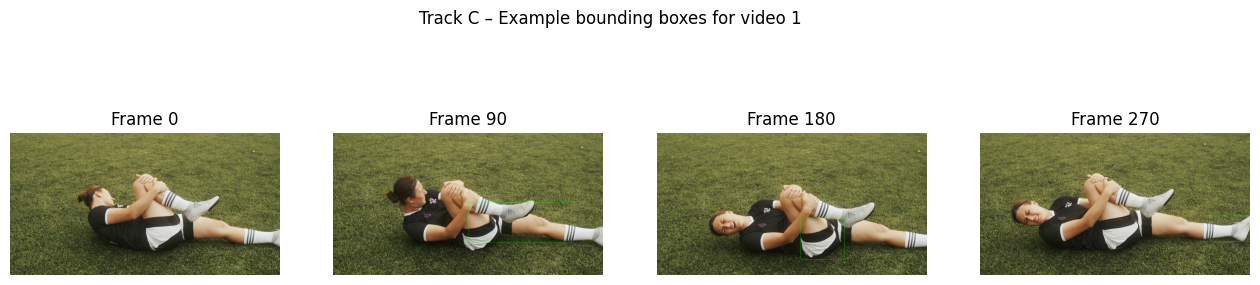


========== Track C – Video 2: /content/Good-young-man-exercising-in-living-room-384624-filmsupply.mov ==========
Saved per-frame spatial metrics to: trackC_spatial_metrics_Good-young-man-exercising-in-living-room-384624-filmsupply.csv


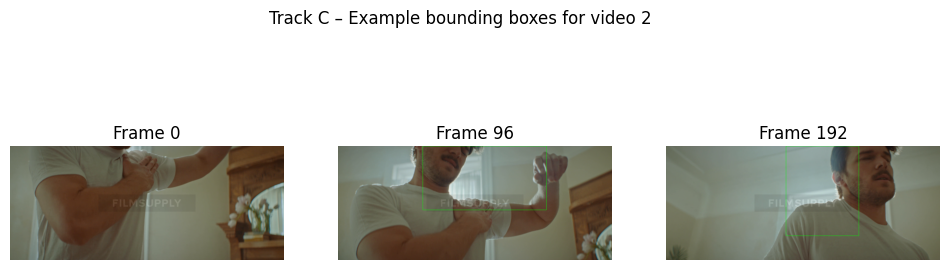


========== Track C – Video 3: /content/5319088-uhd_2160_3840_25fps.mp4 ==========
Saved per-frame spatial metrics to: trackC_spatial_metrics_5319088-uhd_2160_3840_25fps.csv


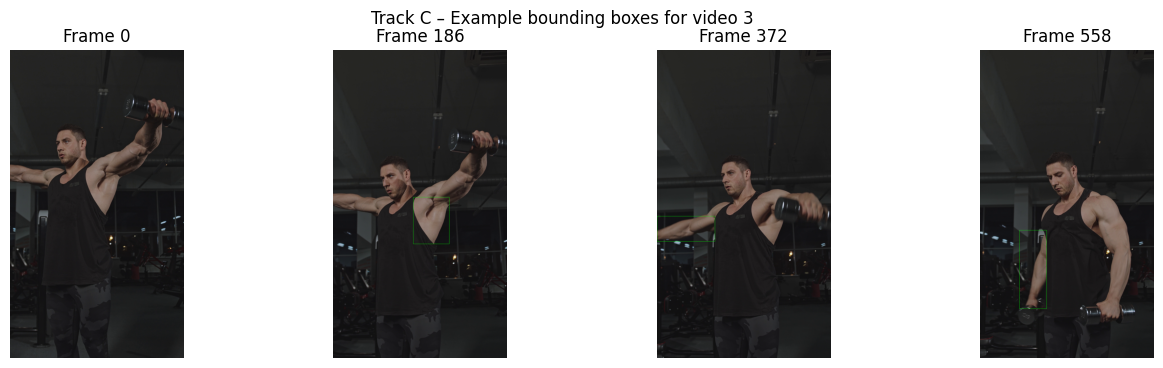

,video_path,duration_s,num_samples,latency_s,rtf,coverage,mean_iou_consecutive,mean_center_disp_norm
0,/content/9517848-uhd_4096_2160_24fps.mp4,11.333333,46,5.133529,2.207708,0.978261,0.319050,0.104065
1,/content/Good-young-man-exercising-in-living-r...,12.012000,48,1.453864,8.262122,0.979167,0.317378,0.126851
2,/content/5319088-uhd_2160_3840_25fps.mp4,22.480000,94,8.202104,2.740760,0.989362,0.289078,0.130625


In [3]:
all_summaries = []

for i, vp in enumerate(video_paths):
    print(f"\n========== Track C – Video {i+1}: {vp} ==========")
    df_c, summary = process_video_spatial(vp, target_fps=4, min_area=200)
    all_summaries.append(summary)

    # Save per-frame spatial metrics
    base = os.path.splitext(os.path.basename(vp))[0]
    out_csv = f"trackC_spatial_metrics_{base}.csv"
    df_c.to_csv(out_csv, index=False)
    print("Saved per-frame spatial metrics to:", out_csv)

    # Quick visualization for first few frames with bbox
    cap = cv2.VideoCapture(vp)
    vis_frames = []
    idx = 0
    wanted_idx = df_c["frame_idx"].iloc[::max(1, len(df_c)//3)].tolist()  # ~3 frames
    wanted_idx = sorted(set(wanted_idx))

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if idx in wanted_idx:
            row = df_c[df_c["frame_idx"] == idx].iloc[0]
            if row["has_bbox"]:
                x, y, w, h = int(row["bbox_x"]), int(row["bbox_y"]), int(row["bbox_w"]), int(row["bbox_h"])
                cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
            vis_frames.append((idx, frame))
        idx += 1

    cap.release()

    # Show the selected frames
    if vis_frames:
        n = len(vis_frames)
        plt.figure(figsize=(4*n, 4))
        for j, (fi, img) in enumerate(vis_frames):
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.subplot(1, n, j+1)
            plt.imshow(img_rgb)
            plt.axis("off")
            plt.title(f"Frame {fi}")
        plt.suptitle(f"Track C – Example bounding boxes for video {i+1}")
        plt.show()

# Build summary DataFrame across videos
df_c_summary = pd.DataFrame(all_summaries)
df_c_summary


In [4]:
# Aggregate Track C metrics across all videos
if not df_c_summary.empty:
    avg_cov  = df_c_summary["coverage"].mean()
    avg_iou  = df_c_summary["mean_iou_consecutive"].mean()
    avg_disp = df_c_summary["mean_center_disp_norm"].mean()
    avg_rtfC = df_c_summary["rtf"].mean()
    avg_latC_ms = (df_c_summary["latency_s"].mean() or 0.0) * 1000.0
else:
    avg_cov = avg_iou = avg_disp = avg_rtfC = avg_latC_ms = float("nan")

summary_rows_C = [
    {
        "metric": "trackC_avg_coverage",
        "value": f"{avg_cov:.3f}",
        "notes": "Avg fraction of sampled frames with detected motion region (spatial coverage) across videos",
    },
    {
        "metric": "trackC_avg_iou_consecutive",
        "value": f"{avg_iou:.3f}",
        "notes": "Avg IoU between consecutive bounding boxes (spatial stability) across videos",
    },
    {
        "metric": "trackC_avg_center_disp_norm",
        "value": f"{avg_disp:.3f}",
        "notes": "Avg normalized center displacement between frames (jitter) across videos",
    },
    {
        "metric": "trackC_avg_latency_ms",
        "value": f"{avg_latC_ms:.2f}",
        "notes": "Avg processing latency for Track C videos (ms)",
    },
    {
        "metric": "trackC_avg_rtf",
        "value": f"{avg_rtfC:.4f}",
        "notes": "Avg real-time factor (video_duration / processing_time) for Track C",
    },
]

SUMMARY_CSV = "metrics_template.csv"
if os.path.exists(SUMMARY_CSV):
    mdf = pd.read_csv(SUMMARY_CSV)
    # ensure correct 3-column structure
    if list(mdf.columns) != ["metric", "value", "notes"]:
        mdf = pd.DataFrame(columns=["metric", "value", "notes"])
else:
    mdf = pd.DataFrame(columns=["metric", "value", "notes"])

mdf = pd.concat([mdf, pd.DataFrame(summary_rows_C)], ignore_index=True)
mdf.to_csv(SUMMARY_CSV, index=False)
print("Updated summary metrics with Track C entries in:", SUMMARY_CSV)
mdf.tail()


Updated summary metrics with Track C entries in: metrics_template.csv


,metric,value,notes
0,trackC_avg_coverage,0.982,Avg fraction of sampled frames with detected m...
1,trackC_avg_iou_consecutive,0.309,Avg IoU between consecutive bounding boxes (sp...
2,trackC_avg_center_disp_norm,0.121,Avg normalized center displacement between fra...
3,trackC_avg_latency_ms,4929.83,Avg processing latency for Track C videos (ms)
4,trackC_avg_rtf,4.4035,Avg real-time factor (video_duration / process...
